In [1]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms
import torchvision.models as models
import cv2


In [2]:
import torchvision
print(torchvision.__version__)


0.12.0+cu102


In [3]:
# get the "features" 
convnext_large= models.convnext_large(pretrained=True).features

# freeze all parameters
for param in convnext_large.parameters():
    param.requires_grad_(False)

In [4]:
# move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

convnext_large.to(device)

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (1): Sequential(
    (0): CNBlock(
      (block): Sequential(
        (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
        (1): Permute()
        (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=192, out_features=768, bias=True)
        (4): GELU()
        (5): Linear(in_features=768, out_features=192, bias=True)
        (6): Permute()
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): CNBlock(
      (block): Sequential(
        (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
        (1): Permute()
        (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=192, out_features=768, bias=True)
        (4): GELU()
        (5): Linear(in_f

In [5]:
def load_image(img_path, max_size=400, shape=None):

    image = Image.open(img_path).convert('RGB')
    
    # set the largest size
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
# load in content and style image
content = load_image('pp1.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('mona.jpg', shape=content.shape[-2:]).to(device)

In [7]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

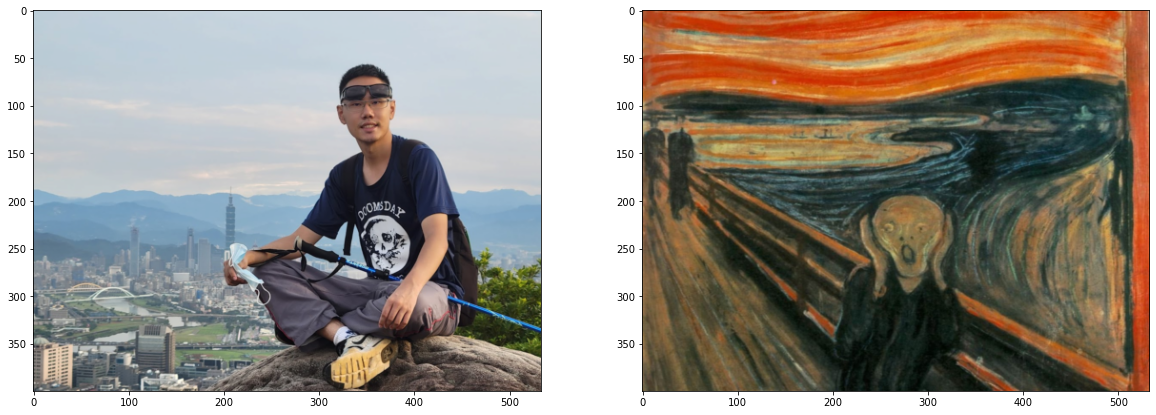

In [8]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

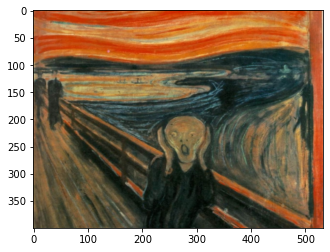

In [9]:
plt.imshow(im_convert(style))

In [10]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '1': 'conv1_2',
                  '3': 'conv2_1', 
                  '6': 'conv3_1', 
                  '7': 'conv4_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        #print(name)
        x = layer(x)
        if name in layers:
            
            features[layers[name]] = x
            
    return features

In [11]:
def gram_matrix(tensor):
    
    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [12]:
# get content and style features before training
content_features = get_features(content, convnext_large)
style_features = get_features(style, convnext_large)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
target = content.clone().requires_grad_(True).to(device)

In [15]:
#calculate the *total* loss
def total_Loss():

    style_weights = {'conv1_1': 1.,
                 'conv1_2': 0.9,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2}

    content_weight = 1  # alpha
    style_weight = 1e8  # beta
    
    # get the features from your target image
    target_features = get_features(target, convnext_large)
    
    # the content loss
    content_loss = torch.mean((target_features['conv3_1'] - content_features['conv3_1'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    return total_loss


Total loss:  5993591.5


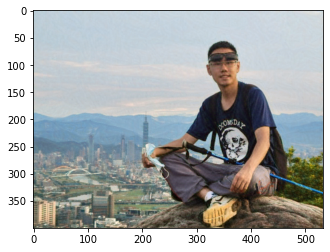

Total loss:  5221661.0


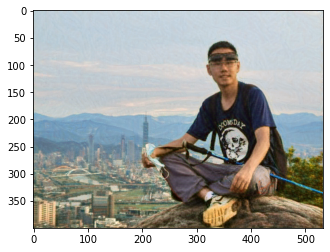

Total loss:  4638518.5


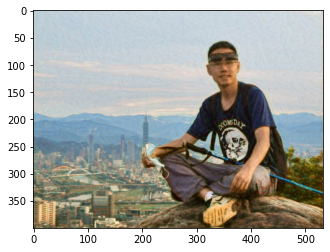

Total loss:  4964518.0


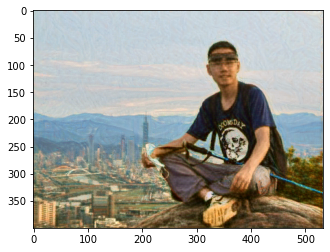

Total loss:  4053218.5


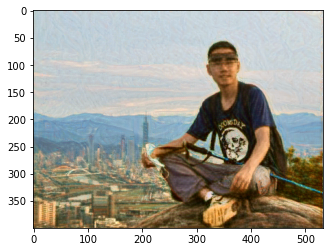

Total loss:  3619950.25


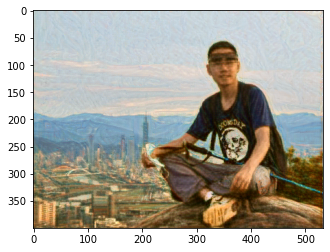

Total loss:  3687787.25


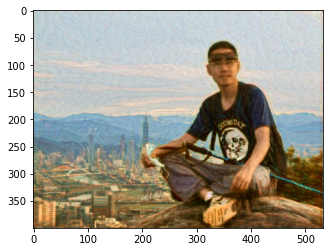

Total loss:  3419395.25


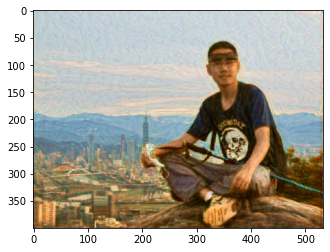

Total loss:  3095266.0


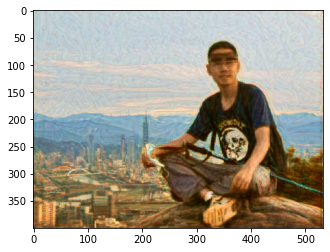

Total loss:  12010839.0


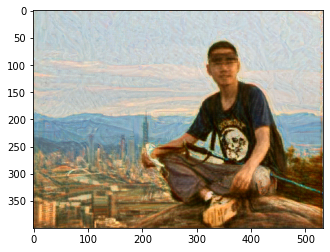

Total loss:  2937372.75


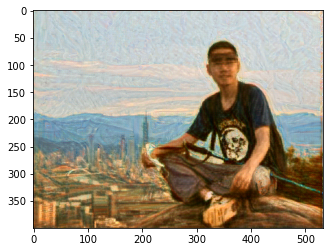

Total loss:  8988163.0


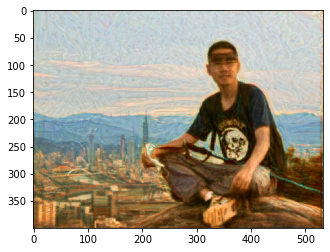

Total loss:  2635599.25


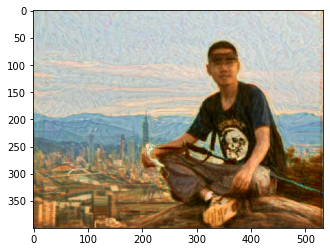

Total loss:  2561162.25


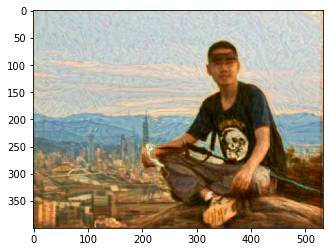

Total loss:  2452360.0


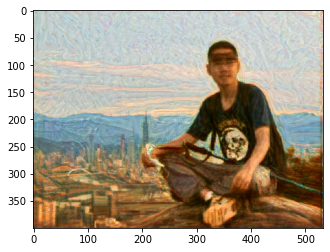

Total loss:  2490743.25


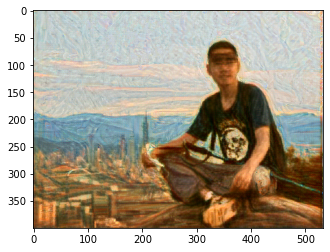

Total loss:  2518866.75


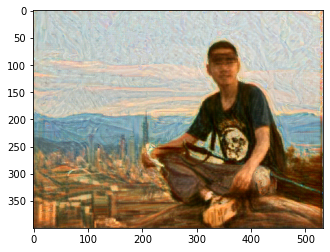

Total loss:  2245840.5


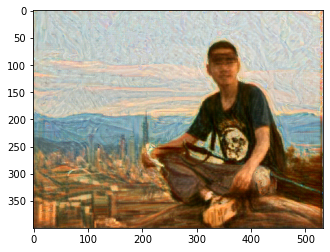

Total loss:  2182658.5


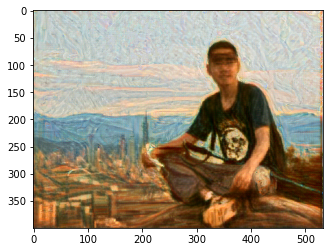

Total loss:  2198706.5


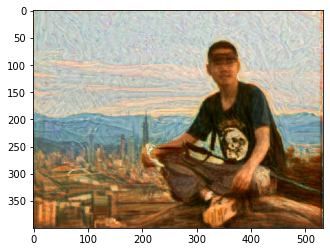

Total loss:  2239491.0


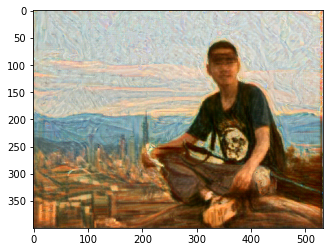

Total loss:  2171376.5


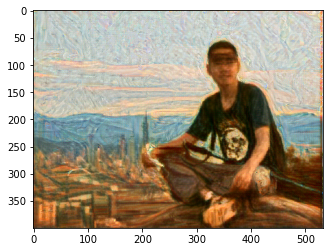

Total loss:  2024145.125


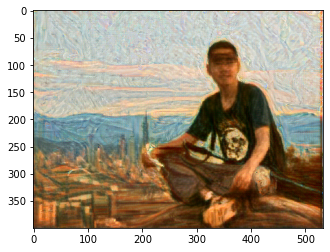

Total loss:  1974785.625


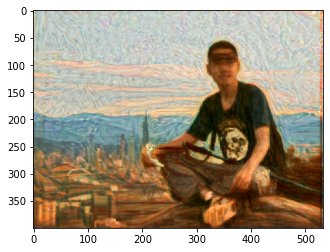

Total loss:  1876397.125


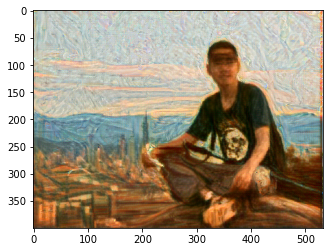

In [16]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 10000  

for i in range(1, steps+1):
    total_loss = total_Loss()
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

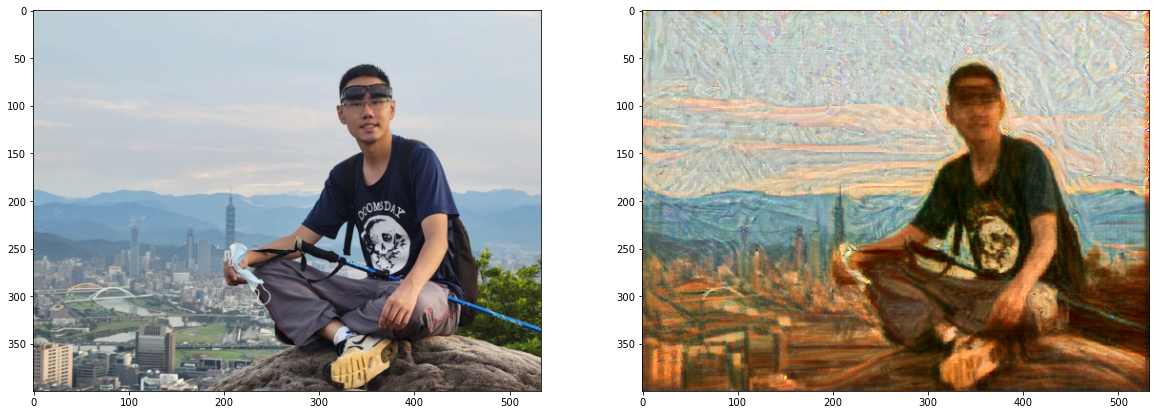

In [17]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

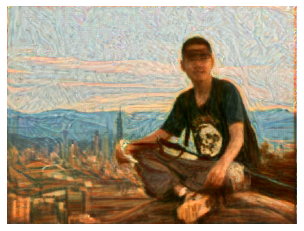

In [18]:
fig=plt.imshow(im_convert(target))
##print(type(im_convert(target)))
#cv2.imwrite('foo1.png', im_convert(target))
plt.axis('off')

#plt.savefig('foo.png')#, bbox_inches='tight', pad_inches=0)
plt.savefig('foo.png', bbox_inches='tight',pad_inches = 0)


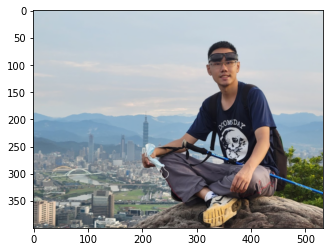

In [19]:
plt.imshow(im_convert(content))